<a href="https://colab.research.google.com/github/htsnet/automacao-de-negocios/blob/master/Automacao_de_Negocios_Mes_Seguinte_Escondido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Uma variação do notebook original, sem split e uso do mês seguinte como validador

# Início: Importação as bibliotecas e Arquivo
É preciso carregar um arquivo CSV com o padrão definido para execução do notebook

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
import datetime
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import seaborn as sns
# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [ ]:
#carrega a tabela de dados
#separador de campos = ;
#ponto decimal = ,
historic = pd.read_csv("/content/Amostra Completa - Mercado Futuro.csv", sep=";", decimal=",")

In [ ]:
#converte o campo data (string) em formato de data
historic['DataFormatada'] = pd.to_datetime(historic['Data'], format='%d/%m/%Y')
historic.head()

,CodOp,Hora Entrada,Hora Saida,Duração,Data,Pentrada,Psaida,Ganhos,Perdas,Resultado,Saldo Trade,K entra,K Saida,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,...,Item 39,Item 40,Item 41,Item 42,Item 43,Item 44,Item 45,Item 46,Item 47,Item 48,Item 49,Item 50,Item 51,Item 52,Item 53,Item 54,Item 55,Item 56,Item 57,Item 58,Item 59,Item 60,Item 61,Item 62,Item 63,Item 64,Item 65,Item 66,Item 67,Item 68,Item 69,Item 70,Item 71,Item 72,Item 73,Item 74,Item 75,Item 76,Item 77,DataFormatada
0,9601,11:00:14,11:14:14,00:13:59,02/01/2019,3876.5,3862.5,0.0,14.0,2,-14.0,120,135,54400,-1800,-11.5,24,460.0,460.0,460.0,460.0,280.0,6800.0,9000.0,11400.0,22.0,52.0,40.5,37.5,-11.0,-6.0,-4.0,1.0,-1.0,-2.0,-58,-0.52,-66,-0.84,-60,...,33,39,41,27,37,44,0,100,500,5,15,5,0,0,-1500,10,10,440,-11,-4.0,-8.5,-9.5,-7.0,-8.5,-9.5,-6.5,-2.0,-1.0,-3.5,-2.0,-1.0,-3.0,0.0,-1.0,0.0,0.0,0.0,2.9,5.4,2019-01-02
1,9602,11:01:15,11:14:29,00:13:14,02/01/2019,3874.5,3859.0,0.0,15.5,2,-15.5,120,135,57600,-2200,-13.5,24,460.0,460.0,460.0,460.0,480.0,6800.0,9000.0,11400.0,38.0,52.0,40.5,37.5,-13.0,-7.0,-4.0,-4.0,-4.0,-2.0,4,0.08,-68,-0.88,-64,...,33,37,36,27,34,41,200,700,500,5,0,5,0,-2800,-1500,90,6690,440,-12,-5.0,-10.5,-11.5,-8.5,-11.0,-11.5,-7.5,-2.0,-1.0,-4.0,-1.5,-1.0,-3.5,-0.5,-1.0,0.0,0.0,0.0,2.9,5.4,2019-01-02
2,9603,11:02:16,11:19:46,00:17:30,02/01/2019,3872.5,3858.0,0.0,14.5,2,-14.5,120,140,57600,-2400,-15.5,24,470.0,460.0,460.0,460.0,1160.0,6800.0,9000.0,11400.0,78.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-5.0,-4.0,-1.0,-54,-0.82,-70,-0.92,-68,...,19,38,29,25,34,36,200,200,1000,15,5,0,0,-400,-5500,20,110,19650,-14,-5.5,-11.5,-14.5,-9.5,-12.5,-14.5,-8.5,-2.5,0.5,-4.5,-2.0,0.5,-4.0,-1.0,-2.5,0.0,0.0,0.0,2.0,5.4,2019-01-02
3,9604,11:03:18,11:19:46,00:16:28,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,57600,-2400,-16.0,24,480.0,460.0,460.0,460.0,1720.0,6800.0,9000.0,11400.0,116.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.94,-68,-0.90,-68,...,18,33,28,26,31,35,-100,100,1000,0,5,0,-800,0,-5500,170,20,19650,-14,-4.5,-12.5,-15.0,-9.5,-13.0,-15.0,-9.5,-1.5,0.5,-5.0,-1.0,0.5,-5.0,-0.5,-2.5,0.0,0.0,0.0,1.8,5.4,2019-01-02
4,9605,11:04:39,11:19:46,00:15:07,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,60800,-2400,-16.0,24,480.0,460.0,460.0,460.0,680.0,6800.0,9000.0,11400.0,36.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.96,-66,-0.88,-68,...,21,37,29,23,38,36,0,100,1000,5,5,0,0,0,-5500,20,20,19650,-14,-3.5,-12.5,-15.0,-8.5,-12.5,-15.0,-10.5,-1.5,0.5,-5.5,-1.5,0.5,-5.0,0.0,-2.5,0.0,0.0,0.0,1.6,5.4,2019-01-02


In [ ]:
#separa um mês em cada  dataframe e faz todas as operações de preparação do daframe criado
variables = locals()
for i in range(1,13):
  mes = str(i).zfill(2)
  variables["mes{0}".format(mes)] = historic[historic['DataFormatada'].dt.month == i]
  #separa o target e o código da operação
  variables["target{0}".format(mes)] = variables["mes{0}".format(mes)][['CodOp', 'Resultado']].copy()
  #indica o campo CodOp como índice nos 2 dataframes (para conferência futura)
  variables["mes{0}".format(mes)] = variables["mes{0}".format(mes)].set_index('CodOp')
  variables["target{0}".format(mes)] = variables["target{0}".format(mes)].set_index('CodOp')
  #apaga o campo target do dataframe original e outros campos já definidos como não necessários
  variables["mes{0}".format(mes)] = variables["mes{0}".format(mes)].drop(['Resultado', 'Hora Entrada', 'Hora Saida',
                                                                          'Duração', 'Data', 'Pentrada', 'Psaida', 'Ganhos',
                                                                          'Perdas', 'Saldo Trade', 'K entra', 'K Saida', 'DataFormatada'], axis=1)

# Criando um arquivo separado com base no mês para teste

In [ ]:
#escolhas dos meses para tratar
mesesTreino = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'] #train
mesValidacao = '12' #test

In [ ]:
#prepara os datasets de acordo com os meses informados
variables = locals()
X_train = variables["mes{}".format(mesesTreino[0])].copy()
for i in range(1, len(mesesTreino)):
  X_train = X_train.append(variables["mes{}".format(mesesTreino[i])])
print(X_train.shape)

X_test = variables["mes{}".format(mesValidacao)].copy()
print(X_test.shape)

#e também dos objetivos para validação
y_train = variables["target{}".format(mesesTreino[0])].copy()
for i in range(1, len(mesesTreino)):
  y_train = y_train.append(variables["target{}".format(mesesTreino[i])])
print(y_train.shape)

y_test = variables["target{}".format(mesValidacao)].copy()
print(y_test.shape)
#converte em array
y_test = y_test.values.ravel()

(36102, 77)
(2966, 77)
(36102, 1)
(2966, 1)


# Modelagem

In [ ]:
#definição de parâmetros para todos os classificadores
estimadores = 200
quantidadeValidacaoCruzada = 30

In [ ]:
#define a apresentação dos resultados das modelagens
def mostraResultado(y_test, valoresPrevistos):
  #lista quantidade de acertos
  contaOk = 0
  contaNao = 0
  contaDesconsiderados = 0
  for i in range(0, len(y_test)):
    if valoresPrevistos[i] == 1  and y_test[i] == 1:
      contaOk += 1
    elif valoresPrevistos[i] == 1  and y_test[i] == 2:
      contaNao += 1
    else:
      contaDesconsiderados += 1

  print("Quantidade de resultados OK: {}\nQuantidade de resultados Não: {}".format(contaOk, contaNao))
  print("Percentual de acertos: {:.1f}%".format(contaOk/(contaOk+contaNao)*100))
  print("Quantidade de resultados desconsiderados: {}".format(contaDesconsiderados))

In [ ]:
#faz a função para gerar modelo 1
def rfc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(1)
  rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1, criterion='entropy', verbose=0)
  cv_scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return rfc

In [ ]:
#gera o modelo
model = rfc_test(X_train, y_train, cv=quantidadeValidacaoCruzada, n_estimators=estimadores)

Média dos 30 testes:  0.37786731240156696


In [ ]:
#fit modelo
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)
#resultado = 1 ou 2
mostraResultado(y_test, valoresPrevistos)

Quantidade de resultados OK: 526
Quantidade de resultados Não: 1129
Percentual de acertos: 31.8%
Quantidade de resultados desconsiderados: 1311


Text(0.5, 15.0, 'Previsão')

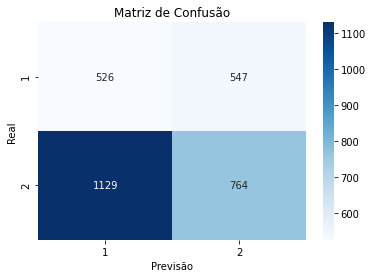

In [ ]:
#gera uma matriz de confusão
cm = confusion_matrix(y_test, valoresPrevistos)
x_axis_labels = [1, 2]
y_axis_labels = [1, 2]
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Previsão')


In [ ]:
#faz a função para gerar modelo 2
def abc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(1)
  abc = AdaBoostClassifier(random_state=2, n_estimators=n_estimators, algorithm='SAMME') 
  cv_scores = cross_val_score(abc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return abc

In [ ]:
#gera o modelo
model = abc_test(X_train, y_train, cv=quantidadeValidacaoCruzada, n_estimators=estimadores)

Média dos 30 testes:  0.48062462173343395


In [ ]:
#fit modelo
model.fit(X_train, y_train.values.ravel())

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=2)

In [ ]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)
#resultado = 1 ou 2
mostraResultado(y_test, valoresPrevistos)

Quantidade de resultados OK: 395
Quantidade de resultados Não: 901
Percentual de acertos: 30.5%
Quantidade de resultados desconsiderados: 1670


In [ ]:
#faz a função para gerar modelo 3
def gbc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(1)
  gbc = GradientBoostingClassifier(random_state=2, n_estimators=n_estimators) 
  cv_scores = cross_val_score(gbc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return gbc

In [ ]:
#gera o modelo
model = gbc_test(X_train, y_train, cv=quantidadeValidacaoCruzada, n_estimators=estimadores)

Média dos 30 testes:  0.42336680575660546


In [ ]:
#fit modelo
model.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)
#resultado = 1 ou 2
mostraResultado(y_test, valoresPrevistos)

Quantidade de resultados OK: 534
Quantidade de resultados Não: 1162
Percentual de acertos: 31.5%
Quantidade de resultados desconsiderados: 1270


In [ ]:
#faz a função para gerar modelo 4 com rede neural Keras
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10)


Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1129/1129 [==============================] - 2s 2ms/step - loss: 609.6044 - accuracy: 0.5038
Epoch 2/10
1129/1129 [==============================] - 2s 1ms/step - loss: 174.3777 - accuracy: 0.5106
Epoch 3/10
1129/1129 [==============================] - 2s 1ms/step - loss: 190.1673 - accuracy: 0.5088
Epoch 4/10
1129/1129 [==============================] - 2s 1ms/step - loss: 159.0345 - accuracy: 0.5119
Epoch 5/10
1129/1129 [==============================] - 2s 1ms/step - loss: 140.6114 - accur

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

93/93 - 0s - loss: 161.7108 - accuracy: 0.3655

Test accuracy: 0.3654753863811493


In [ ]:
#faz a função para gerar modelo 5 com rede neural keras
model = Sequential()
model.add(Dense(288, activation='relu', input_dim=77))
model.add(Dense(288, activation='relu'))
model.add(Dense(144, activation='relu'))
model.add(Dense(144, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, batch_size=500, validation_data=(X_test, y_test))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 288)               22464     
_________________________________________________________________
dense_26 (Dense)             (None, 288)               83232     
_________________________________________________________________
dense_27 (Dense)             (None, 144)               41616     
_________________________________________________________________
dense_28 (Dense)             (None, 144)               20880     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 145       
Total params: 168,337
Trainable params: 168,337
Non-trainable params: 0
_________________________________________________________________
Train on 36102 samples, validate on 2966 samples
Epoch 1/200
36102/36102 [==============================] - 1s 37u

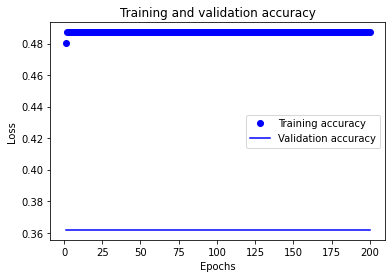

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

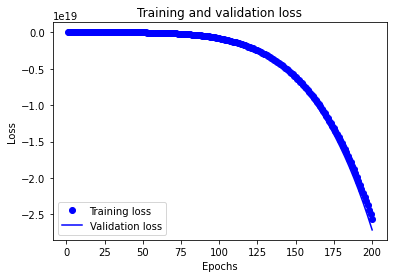

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_test

array([2, 2, 2, ..., 1, 1, 1])

In [ ]:
len(valoresPrevistos)

2966

In [ ]:
valoresPrevistos

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_test)
#resultado = 1 ou 2
mostraResultado(y_test, valoresPrevistos)

Quantidade de resultados OK: 1073
Quantidade de resultados Não: 1893
Percentual de acertos: 36.2%
Quantidade de resultados desconsiderados: 0
